# Example 2: GCE Point Source Monte Carlo Simulation

This example covers how to run a point source Monte Carlo simulation for a given template and source count distribution (SCD) with NPTFit-Sim. In this example we use a Galactic Center Excess (GCE) template to produce a simulated counts map. The counts map is then run through NPTFit to recover the injected SCD.

The relevant modules are imported.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../NPTFit-Sim/')
import ps_mc
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

## Download the Fermi Data

For this example the Fermi data is required, so we begin by downloading it.

In [2]:
# Assumes wget is available! Otherwise, use curl or download manually 
# from https://dspace.mit.edu/handle/1721.1/105492
os.system("wget https://dspace.mit.edu/bitstream/handle/1721.1/105492/fermi_data.tar.gz");
os.system("tar -xvf fermi_data.tar.gz");
os.system("rm -r fermi_data.tar.gz*");

## Define Source Count Distribution & Load Templates

Define the source count distribution. Here we use a SCD with one break.

In [3]:
n = np.array([17.79,-0.99]) # indexes for SCD
S = np.array([14.29]) # SCD break, here in terms of counts
A = -2.34 # log-normilization
name = "example" # Name of output file

Load in the GCE template and exposure map.

In [4]:
temp = "fermi_data/template_gce.npy"
temp = np.load(temp)
exp = "fermi_data/fermidata_exposure.npy"

The SCD as described above is in terms of counts. NPTFit-Sim uses source count distributions that are defined in terms of flux, i.e. dN/dF as opposed to dN/dS. The two distributions are related by the exposure as follows:

$$\frac{dN_{p}}{dS}(S;\theta) = \frac{1}{E_{p}} \frac{dN_{p}}{dF}(F = S/E_{p};\theta)$$

To correct for this effect, the mean exposure is calculated from the Fermi exposure map and divided through the count break, $S$, to form a flux break. Additionally, the log-normilization, $A$, is multiplied by the log-mean exposure to transform the SCD in terms of counts to flux.

In [5]:
# Calculate the mean Fermi exposure
EXP = np.load(exp)
mean_exp = np.mean(EXP)
# Convert from counts to flux
F = S / mean_exp
# Multiply log-normilization term, A, by log-mean exposure to convert to SCD in terms of flux.
cor_term = np.log10(mean_exp)
A = A + cor_term

rescale = EXP / mean_exp
temp = temp / rescale

## User Defined PSF

Prior to running the simulation, the user must define a PSF using a lambda function. For simulating Fermi LAT data, a double King function is defined for a PSF at 2 GeV in this example. Note: depending on how your PSF is defined you will need to include the Jacobian factor.

In [6]:
# Define parameters that specify the Fermi-LAT PSF at 2 GeV
fcore = 0.748988248179
score = 0.428653790656
gcore = 7.82363229341
stail = 0.715962650769
gtail = 3.61883748683
spe = 0.00456544262478

# Define the full PSF in terms of two King functions
def king_fn(x, sigma, gamma):
    return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

def Fermi_PSF(r):
    return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

# Lambda function to pass user defined PSF, includes Jacobian factor
psf_r = lambda r: Fermi_PSF(r)

## Run NPTFit-Sim

Number of sources from Poisson draw: 903
Sampling the source count distribution.
Simulating counts map ...
Done simulation.


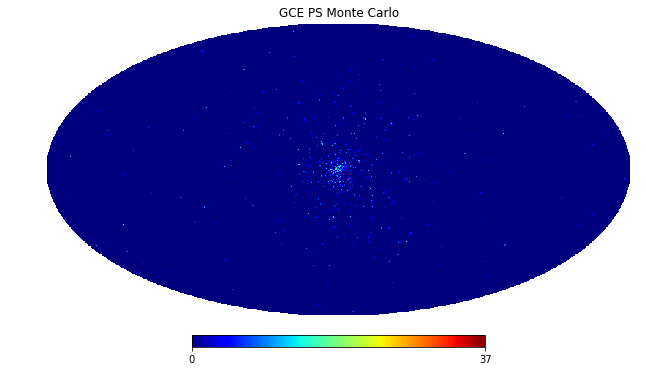

In [7]:
sim = ps_mc.run(n,F,A,temp,EXP,psf_r)
hp.mollview(sim,title="GCE PS Monte Carlo")

With our simulation of the GCE complete, we want to see if we can recover the injected source count distribution. To do this, we will use NPTFit.
# Recover SCD with NPTFit
To recover the injected source count distribution, we will run NPTFit using only the GCE PS templates. First, load in the relevant modules.

In [8]:
from NPTFit import nptfit
from NPTFit import create_mask as cm
from NPTFit import dnds_analysis
from NPTFit import psf_correction as pc

## Set Up Scan
Begin with NPTFit as you normally would.

In [9]:
n = nptfit.NPTF(tag='GCE_Example')
n.load_data(sim,EXP)

Load in the GCE template and scale it with exposure map.

In [10]:
gce = np.load("fermi_data/template_gce.npy")
# Remove exposure correction for PS
rescale = EXP / np.mean(EXP)
n.add_template(gce / rescale, 'gce_np', units='PS')

Add the relevant non-poisson model.

In [11]:
n.add_non_poiss_model('gce_np',
                      ['$A_\mathrm{gce}^\mathrm{ps}$','$n_1^\mathrm{gce}$','$n_2^\mathrm{gce}$','$S_b^{(1), \mathrm{gce}}$'],
                      [[-6.,1.],[2.05,30],[-2.0,1.95],[0.05,40.0]],
                      [True,False,False,False])

Calculate the PSF correction for the Fermi PSF.

In [12]:
pc_inst = pc.PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
pc_inst.psf_samples = 10000
pc_inst.psf_tag = 'fermi_psf_2GeV'
pc_inst.make_or_load_psf_corr()

f_ary = pc_inst.f_ary
df_rho_div_f_ary = pc_inst.df_rho_div_f_ary

File saved as: /zfs/nrodd/NPTFit-Sim/examples/psf_dir/fermi_psf_2GeV.npy


Now configure and run the scan.

In [13]:
n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=4)
n.perform_scan(nlive=200)

No mask set; defaulting to a blank mask
The number of parameters to be fit is 4


When the scan is complete, make a triangle plot and plot the extracted SCD.

  analysing data from /zfs/nrodd/NPTFit-Sim/examples/chains/GCE_Example/.txt


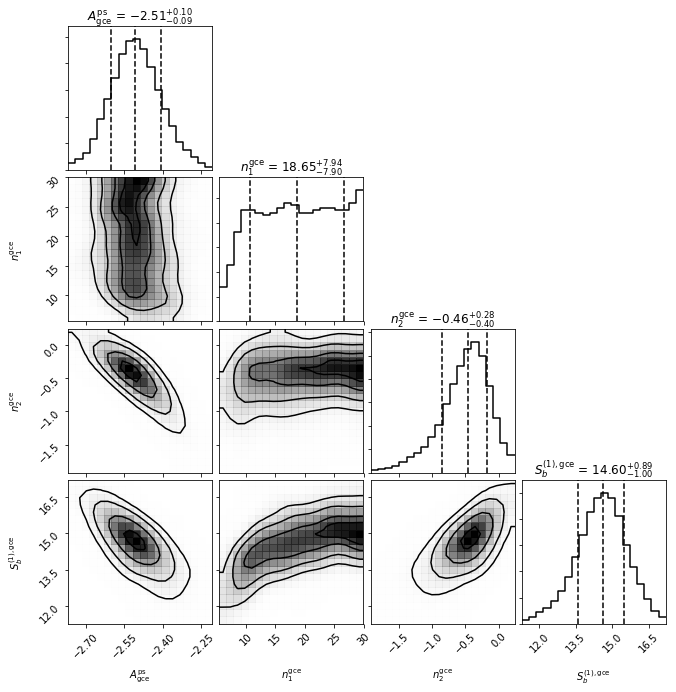

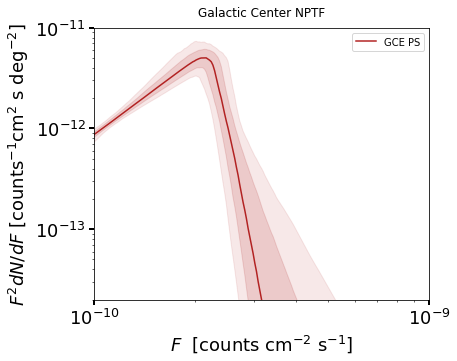

In [14]:
n.load_scan()

an = dnds_analysis.Analysis(n)

an.make_triangle()

plt.figure(figsize=[6,5])

an.plot_source_count_median('gce_np',smin=0.01,smax=1000,nsteps=1000,color='firebrick',spow=2,label='GCE PS')
an.plot_source_count_band('gce_np',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='firebrick',alpha=0.15,spow=2)
an.plot_source_count_band('gce_np',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='firebrick',alpha=0.1,spow=2)

plt.xlim([1e-10,1e-9])
plt.ylim([2e-14,1e-11])
plt.yscale('log')
plt.xscale('log')
plt.tick_params(axis='x', length=5, width=2, labelsize=18)
plt.tick_params(axis='y', length=5, width=2, labelsize=18)
plt.ylabel('$F^2dN/dF$ [counts$^{-1}$cm$^2$ s deg$^{-2}$]', fontsize=18)
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]', fontsize=18)
plt.title('Galactic Center NPTF', y=1.02)
plt.legend(fancybox=True)

As you can see from the fit, these results agree with our original injected source count distribution used in NPTFit-Sim.